In [14]:
import requests
from bs4 import BeautifulSoup

# Get data from url 
URL = "https://gearvn.com/collections/laptop-gaming-ban-chay"
r = requests.get(URL)
   
soup = BeautifulSoup(r.content, 'html.parser')
content_product_list = soup.find('div', attrs= {'class': 'row content-product-list'})
items = []
# Get item each row
for item in content_product_list.findAll('div', attrs= {'class': 'product-row'}):
    product_name = item.find('h2', attrs= {'class': 'product-row-name'})
    old_price = item.find('div', attrs= {'class': 'product-row-price pull-left'}).find('del')
    new_price = item.find('span', attrs= {'class': 'product-row-sale'})
    new_product_percent = item.find('div', attrs= {'class': 'new-product-percent'})
    best_seller = item.find('span', attrs = {'class': 'ico-product ico-km'})
    items.append({
        'product_name': product_name.text.strip(),
        'old_price': old_price.text.strip(),
        'new_price': new_price.text.strip(),
        'percent_discount': new_product_percent.text.strip(),
        'best_seller': 1 if best_seller and best_seller.text.strip() == 'Best Seller' else 0,
    })
print('Raw data: ')
print('items: ', items)
brands = []
# Inspect menu to load brand
menu_items = soup.findAll('li', attrs= {'class': 'cat-menu-item'})
for menu_item in menu_items:
    menu_name = menu_item.find('span', attrs = {'class': 'gearvn-cat-menu-name'})
    # Filter laptop gaming category
    if menu_name and menu_name.text.strip() == 'Laptop Gaming':
        sub_cat_items = menu_item.findAll('div', attrs = {'class': 'sub-cat-item'})
        for sub_cat_item in sub_cat_items:
            sub_cat_item_name = sub_cat_item.find('a', attrs = {'class' : 'sub-cat-item-name'})
            # Filter brand links
            if sub_cat_item_name and sub_cat_item_name.text.strip() == 'Thương hiệu':
                sub_cat_item_filters = sub_cat_item.findAll('a', attrs = {'class': 'sub-cat-item-filter'})
                for sub_cat_item_filter in sub_cat_item_filters:
                    brands.append(sub_cat_item_filter.text.strip())
            break
        break
        
print('brands: ', brands)

Raw data: 
items:  [{'product_name': 'Laptop gaming Gigabyte G5 GD 51VN123SO', 'old_price': '20,490,000₫', 'new_price': '19,490,000₫', 'percent_discount': '-5%', 'best_seller': 1}, {'product_name': 'Laptop Gaming Acer Nitro 5 Eagle AN515 57 53F9', 'old_price': '25,990,000₫', 'new_price': '20,990,000₫', 'percent_discount': '-19%', 'best_seller': 0}, {'product_name': 'Laptop Gaming Gigabyte G5 GE 51VN263SH', 'old_price': '25,590,000₫', 'new_price': '21,690,000₫', 'percent_discount': '-15%', 'best_seller': 1}, {'product_name': 'Laptop Lenovo IdeaPad Gaming 3 15IAH7 82S9006YVN', 'old_price': '26,990,000₫', 'new_price': '21,490,000₫', 'percent_discount': '-20%', 'best_seller': 1}, {'product_name': 'Laptop ASUS TUF Gaming F15 FX506LHB HN188W', 'old_price': '20,990,000₫', 'new_price': '16,990,000₫', 'percent_discount': '-19%', 'best_seller': 0}, {'product_name': 'Laptop Gaming Acer Aspire 7 A715 42G R05G', 'old_price': '20,990,000₫', 'new_price': '16,990,000₫', 'percent_discount': '-19%', 'be

In [15]:
import pandas as pd

# Get brand (process for sub brand case like ASUS/TUF)
def get_brand(brand):
    arr = brand.split('/')
    if len(arr) == 2:
        return arr[0].strip()
    return brand.strip()

raw_brand_items = pd.DataFrame(brands)
raw_brand_items

brands = list(map(get_brand, brands))
brands

['ACER', 'ASUS', 'MSI', 'LENOVO', 'DELL', 'GIGABYTE', 'HP']

In [16]:
import pandas as pd

def get_bool(row):
    return row['best_seller'] == 1

def get_brands_from_title(title, brands):
    words = title.split(' ')
    for idx, word in enumerate(words):
        for brand in brands:
            if word.upper() == brand.upper():
                return [brand, ' '.join([str(x) for x in words[idx + 1: ]])]
            
raw_product_items = pd.DataFrame(items)
raw_brand_items = pd.DataFrame(brands)

# Create brand and name of product
brand_names = []
for product_name in raw_product_items["product_name"]:
    brand_names.append(get_brands_from_title(product_name, brands))
raw_product_items[['brand', 'name']] = brand_names

# Clean up row
raw_product_items["old_price_int"] = raw_product_items["old_price"].str.replace(',', '').str.extract('(\d+)')
raw_product_items["new_price_int"] = raw_product_items["new_price"].str.replace(',', '').str.extract('(\d+)')
raw_product_items["percent_discount"].replace('[-%]', '',  regex=True, inplace=True)
raw_product_items["percent_discount_int"] = raw_product_items["percent_discount"].astype(int)

# Convert datatype
raw_product_items["old_price_int"] = raw_product_items["old_price_int"].astype(int)
raw_product_items["new_price_int"] = raw_product_items["new_price_int"].astype(int)
raw_product_items["percent_discount_int"] = raw_product_items["percent_discount_int"].astype(int)
raw_product_items["best_seller_bool"] = raw_product_items.apply(get_bool, axis=1)
raw_product_items["brand"] = raw_product_items["brand"].astype(str)
raw_product_items["name"] = raw_product_items["name"].astype(str)

# Create new dataframe
product_items =raw_product_items[[ "brand", "name", "old_price_int", "new_price_int", "percent_discount_int", "best_seller_bool"]]
product_items = product_items.rename(columns={
    "brand": "Brand",
    "name": "Name",
    "old_price_int": "OldPrice",
    "new_price_int": "NewPrice",
    "percent_discount_int": "PercentDiscount",
    "best_seller_bool": "BestSeller"
})

# Print laptop dataframe info
product_items.info()
# Print laptop
product_items

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Brand            28 non-null     object
 1   Name             28 non-null     object
 2   OldPrice         28 non-null     int32 
 3   NewPrice         28 non-null     int32 
 4   PercentDiscount  28 non-null     int32 
 5   BestSeller       28 non-null     bool  
dtypes: bool(1), int32(3), object(2)
memory usage: 940.0+ bytes


,Brand,Name,OldPrice,NewPrice,PercentDiscount,BestSeller
0,GIGABYTE,G5 GD 51VN123SO,20490000,19490000,5,True
1,ACER,Nitro 5 Eagle AN515 57 53F9,25990000,20990000,19,False
2,GIGABYTE,G5 GE 51VN263SH,25590000,21690000,15,True
3,LENOVO,IdeaPad Gaming 3 15IAH7 82S9006YVN,26990000,21490000,20,True
4,ASUS,TUF Gaming F15 FX506LHB HN188W,20990000,16990000,19,False
5,ACER,Aspire 7 A715 42G R05G,20990000,16990000,19,True
6,MSI,Katana GF66 11UE 836VN,32990000,25990000,21,False
7,ASUS,TUF Gaming F15 FX506HC HN144W,25990000,19990000,23,True
8,ACER,Aspire 7 A715 43G R8GA,22990000,18990000,17,False
9,ACER,Nitro 5 Eagle AN515 57 54MV,25990000,20790000,20,False


          Old Price (VND)  New Price (VND)
Brand                                     
ACER           25990000.0       20890000.0
ASUS           28990000.0       22990000.0
GIGABYTE       26390000.0       22990000.0
HP             27890000.0       20990000.0
LENOVO         26990000.0       21490000.0
MSI            27990000.0       22490000.0


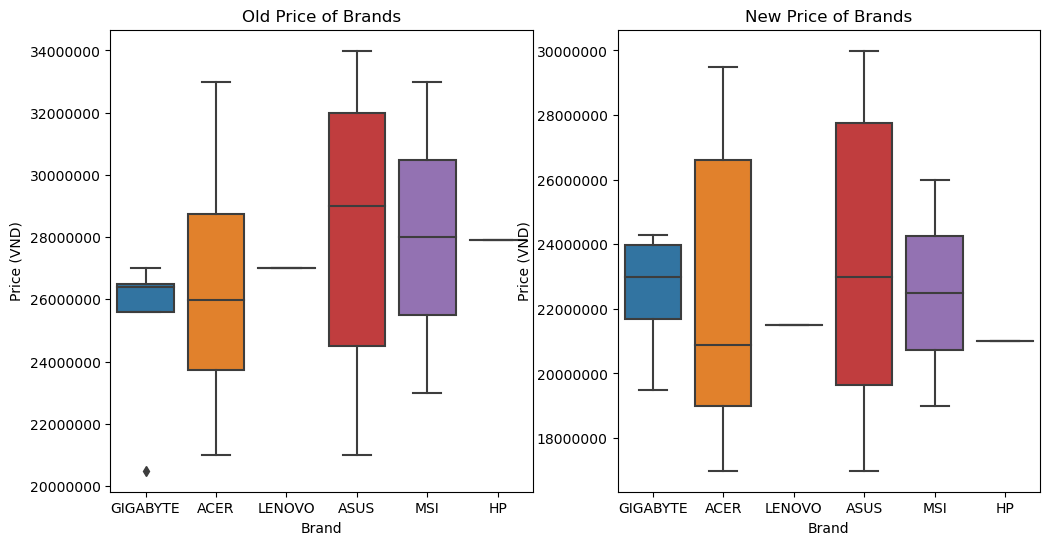

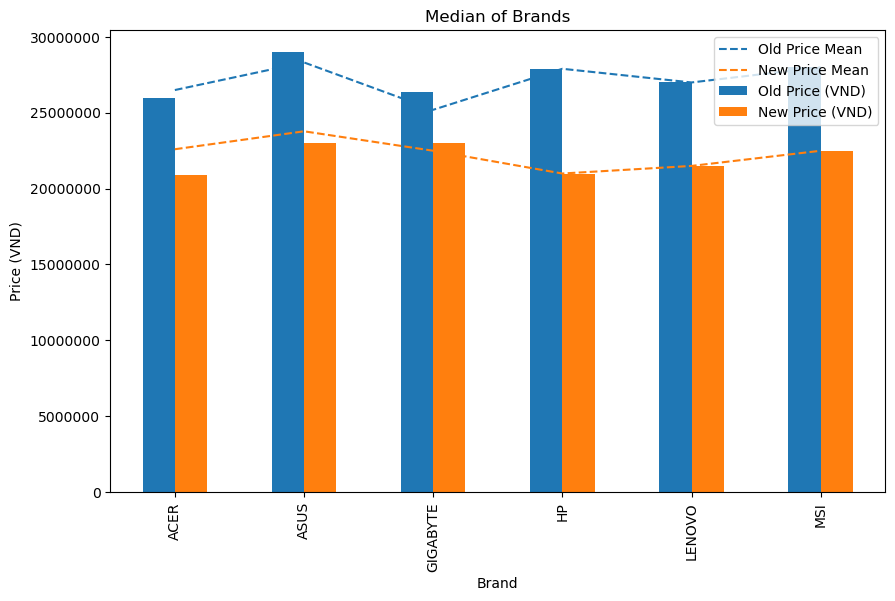

In [17]:
# Trực quan trung bình và trung vị giá bán cũ và mới với các Brand. Cho nhận xét
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Group by brand name
df = product_items.groupby('Brand')[['OldPrice', 'NewPrice']].median()
df = df.rename(columns = {
    "OldPrice": "Old Price (VND)",
    "NewPrice": "New Price (VND)",
})
print(df)
# Create boxplot chart to compare price
agg_df = product_items.groupby("Brand").agg({"OldPrice": ["mean", "median"], "NewPrice": ["mean", "median"]})
agg_df.columns = ["Old Price Mean", "Old Price Median", "New Price Mean", "New Price Median"]
agg_df = agg_df.reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x="Brand", y="OldPrice", data=product_items, ax=axs[0])
sns.boxplot(x="Brand", y="NewPrice", data=product_items, ax=axs[1])

axs[0].set_title("Old Price of Brands")
axs[1].set_title("New Price of Brands")

axs[0].set_ylabel("Price (VND)")
axs[1].set_ylabel("Price (VND)")
axs[0].ticklabel_format(style = "plain", axis="y", useOffset=True) 
axs[1].ticklabel_format(style = "plain", axis="y", useOffset=True) 

plt.show()
# Create bar chart
ax = df.plot(kind='bar', figsize=(10,6));
# Create two line mean of old price and new price
mean = product_items.groupby('Brand')[['OldPrice', 'NewPrice']].mean()
ax.plot(mean.index, mean['OldPrice'], label='Old Price Mean', linestyle='--')
ax.plot(mean.index, mean['NewPrice'], label='New Price Mean', linestyle='--')
# Set format
ax.set_title("Median of Brands")
ax.set_ylabel("Price (VND)");
ax.legend()
plt.ticklabel_format(style = 'plain', axis='y')

plt.show()

#### Nhận xét:
- Hầu hết các Laptop Gaming của Gearvn có khoảng giá cũ từ hơn 24 triệu - hơn 30 triệu đồng, giá mới từ 19 - dưới 28 triệu đồng. Giá mới thấp hơn giá cũ.
- Asus, Acer và MSI có phổ giá rộng, đa dạng về chi phí.
- Giá bán của laptop Acer, HP giá bán trung bình thấp hơn các thương hiệu còn lại, Laptop ASUS cao hơn các hãng khác.
- Tỉ lệ giảm giá của các hãng gần như tương đồng ngoài trừ Gigabyte giảm giá ít, HP giảm giá nhiều
- Gigabyte và Asus có các sản phẩm khoảng cách giá chênh lệch so với giá trung bình ở cả giá cũ và giá mới:
> - ASUS có giá cũ trung vị cao hơn giá cũ trung bình nhưng giá mới trung vị thấp hơn giá mới trung bình
> - Gigabyte có giá cũ trung vị cao hơn giá cũ trung bình và giá mới trung vị cao hơn giá mới trung bình

      Brand  counts
0      ASUS      11
1      ACER       8
2  GIGABYTE       5
3       MSI       2
4        HP       1
5    LENOVO       1
Total:  28


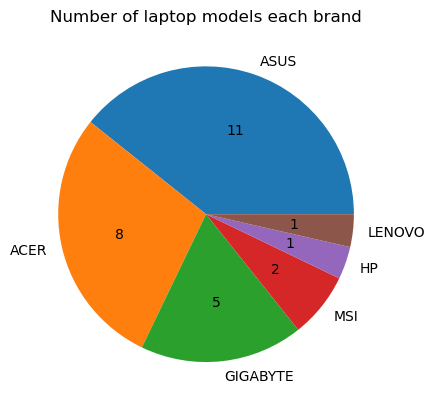

In [18]:
# Trực quan đếm số sản phẩm của các Brand. Cho nhận xét
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
total_size = product_items.shape[0]
def absolute_value(val):
    a  = np.round(val/100.*total_size, 0)
    return a.astype(int)

# Count product by brand
df = product_items.groupby('Brand').size().reset_index(name='counts')
df = df.sort_values(by=['counts'], ascending=False)
df.reset_index(drop=True, inplace=True)
print(df)
print('Total: ', total_size)

# Display pie chart
fig, ax = plt.subplots()
ax.pie(df['counts'], labels = df['Brand'], autopct = absolute_value)
ax.set_title("Number of laptop models each brand")
plt.show()


#### Nhận xét:
- Thị phần laptop gaming tại Gearvn đang được chiếm nhiều ASUS, tiếp đến là ACER và Gigabyte
- HP và LENOVO có chỉ 1 model laptop gaming
- Các nhà sản xuất từ Đài Loan như ASUS, ACER, Gigabyte cung cấp nhiều mẫu Laptop Gaming đang chiếm thị phần lớn về các mẫu laptop gaming của nhà cung cấp Gearvn

          Max Percent Discount  Min Percent Discount
Brand                                               
HP                          25                    25
ASUS                        23                     6
MSI                         21                    17
ACER                        21                     7
LENOVO                      20                    20
GIGABYTE                    15                     5


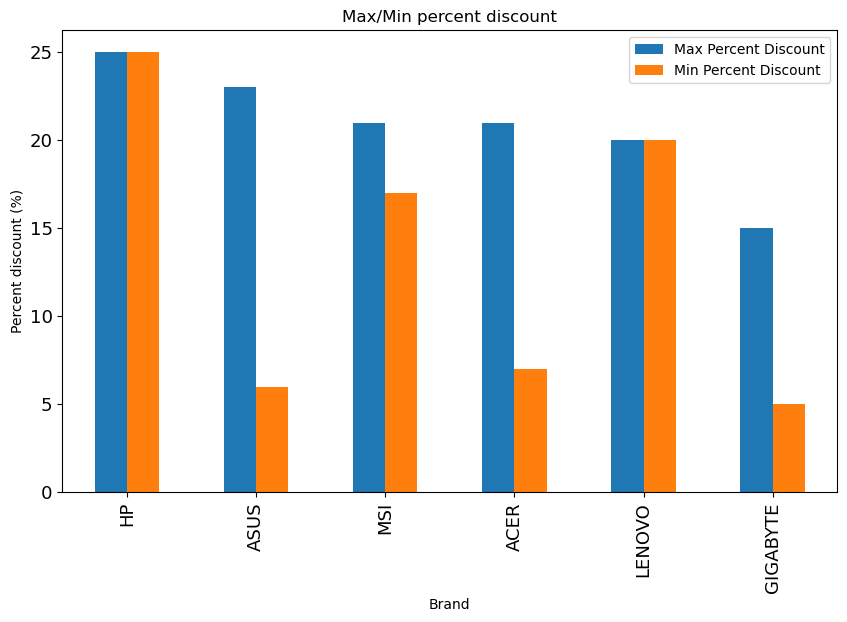

In [19]:
# Trực quan mức giảm giá cao nhất và thấp nhất của sản phẩm mỗi Brand. Cho nhận xét
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# grouping brand and percent discount
group = product_items.groupby('Brand')[['PercentDiscount']]
# Get max/min and merge into one dataframe
maxDf = product_items.groupby('Brand')[['PercentDiscount']].max()
minDf = product_items.groupby('Brand')[['PercentDiscount']].min()

maxMinDf = maxDf.merge(minDf, how='inner', on="Brand")
maxMinDf = maxMinDf.rename(columns={
    "Brand": "Brand",
    "name": "Name",
    "PercentDiscount_x": "Max Percent Discount",
    "PercentDiscount_y": "Min Percent Discount"
})
maxMinDf = maxMinDf.sort_values(by=['Max Percent Discount', 'Min Percent Discount'], ascending=False)
print(maxMinDf)


ax = maxMinDf.plot(kind='bar', figsize=(10,6), fontsize=13);
ax.set_title("Max/Min percent discount")
ax.set_ylabel("Percent discount (%)");
ax.set_xlabel("Brand");
plt.ticklabel_format(style = 'plain', axis='y')
plt.show()

#### Nhận xét
- Sản phẩn ASUS và ACER giảm giá không đồng đều, chêch lệch hơn (đa dạng mẫu mã nhưng một số mặt hàng giảm giá sâu để bán ra)
- HP chỉ có duy nhất một laptop đang giảm giá và giảm 25%
- MSI giảm giá nhiều các mẫu: tỉ lệ giảm giá cao nhất và thấp nhất gần đồng đều (đều cao) (dự đoán: đa phần mẫu laptop của MSI cần được bán ra)

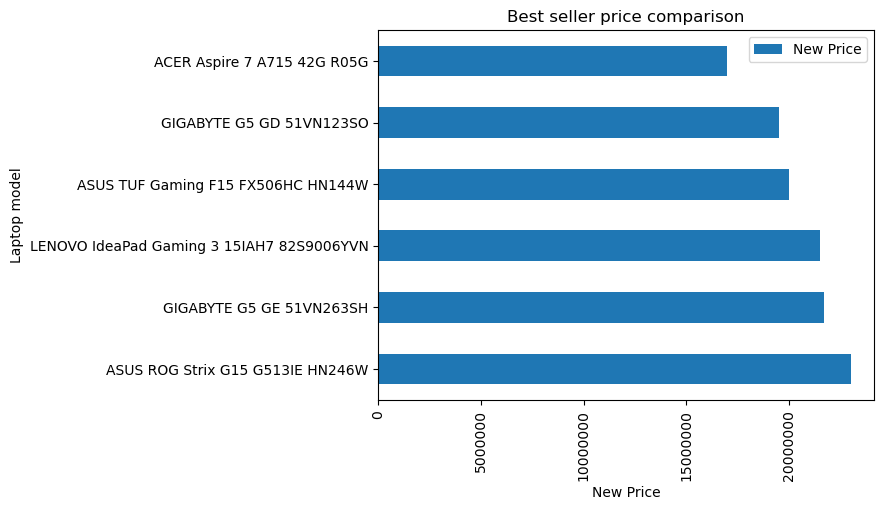

In [20]:
# Trực quan mức giá mới của các sản phẩm là BestSeller. Cho nhận xét
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filt best seller laptop
best_seller = product_items[product_items["BestSeller"] == True]
df = best_seller[["Brand", "Name", "NewPrice"]]
df = df.sort_values(by=["NewPrice"], ascending=False)
df = df.rename(columns = {
    "NewPrice": "New Price",
})
df["BrandName"] = df["Brand"] + " " + df["Name"]
df = df.set_index('BrandName')

# Create horizontal bar chart
ax = df.plot.barh();

ax.set_title("Best seller price comparison")
ax.set_ylabel("Laptop model");
ax.set_xlabel("New Price");
plt.xticks(rotation=90)
plt.ticklabel_format(style = 'plain', axis='x')
plt.show()


#### Nhận xét
- Toàn bộ Laptop Best Seller có giá tốt đều đến từ nhà sản xuất Đài Loan
- Các laptop best seller có giá từ hơn 15 triệu tới hơn 20 triệu
- Laptop Aspire 7 A715 42G R05G có giá thấp nhất trong các laptop Best Seller (hơn 15 triệu VND một ít)


In [21]:
# Import pymysql module
import pymysql
# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='password',
                             db='laptop')
cursor = connection.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS `laptopbestseller` (
      `Id` int NOT NULL AUTO_INCREMENT,
      `Name` text,
      `Brand` text,
      `OldPrice` int DEFAULT NULL,
      `NewPrice` int DEFAULT NULL,
      `PercentDiscount` int DEFAULT NULL,
      `BestSeller` tinyint(1) DEFAULT NULL,
      PRIMARY KEY (`Id`)
    )
""")

# creating column list for insertion
cols = ",".join([str(i) for i in product_items.columns.tolist()])

# Insert DataFrame records one by one.
for i,row in product_items.iterrows():
    sql = "INSERT INTO LAPTOPBESTSELLER (" + cols + ") VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))

    # the connection is not autocommitted by default, so we must commit to save our changes
connection.commit()